# Assignment 7: Dimensionality Reduction

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking **'Runtime' > 'Restart session and run all'**.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

# Dataset

In this assignment, you will work on a text dataset. The Yelp reviews dataset consists of reviews from Yelp. It is extracted from the Yelp Dataset Challenge 2015 data. For more information, please refer to http://www.yelp.com/dataset_challenge. The Yelp reviews polarity dataset is a subset of Yelp reviews dataset and is constructed by considering stars 1 and 2 negative, and 3 and 4 positive.

In [91]:
# imports
import os
import numpy as np
import pandas as pd
import polars as pl
from scipy.sparse import csr_matrix
import sklearn.feature_extraction.text as sktext
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
import re
from sklearn.manifold import TSNE

import umap

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [92]:
# !gdown https://drive.google.com/uc?id=1A0-Q7SbdoA3r7aawraRSwMgKujBYlFLv

# Part 1: Data Preprocessing

## Question 1.1: Load data

Read the **`yelp.csv`** file as a **`polars.DataFrame`** and show the first 5 rows of the dataframe and its descriptive statistics.

In [93]:
# Load the dataset
df = pl.read_csv("yelp.csv")

# Display the first 5 rows
print(df.head(5))

# Show descriptive statistics
print(df.describe())

shape: (5, 2)
┌───────────┬─────────────────────────────────┐
│ Sentiment ┆ Review                          │
│ ---       ┆ ---                             │
│ i64       ┆ str                             │
╞═══════════╪═════════════════════════════════╡
│ 0         ┆ Maintenance here is ridiculous… │
│ 1         ┆ I really enjoy smaller more in… │
│ 1         ┆ Looking at their menu, I was a… │
│ 1         ┆ Best sandwiches in Las Vegas! … │
│ 0         ┆ Was upset because they didnt h… │
└───────────┴─────────────────────────────────┘
shape: (9, 3)
┌────────────┬───────────┬─────────────────────────────────┐
│ statistic  ┆ Sentiment ┆ Review                          │
│ ---        ┆ ---       ┆ ---                             │
│ str        ┆ f64       ┆ str                             │
╞════════════╪═══════════╪═════════════════════════════════╡
│ count      ┆ 1500.0    ┆ 1500                            │
│ null_count ┆ 0.0       ┆ 0                               │
│ mean       ┆ 0.

## Question 1.2: Convert categorical variable

Since we are not predicting the categorical variable in this assignment, let's convert **`Sentiment`** to string:
- Replace **1** with **`positive`**.
- Replace **0** with **`negative`**.

Display the first 5 rows of the resulting dataframe.


In [94]:
# Convert Sentiment column
df = df.with_columns(
  df["Sentiment"].cast(pl.Utf8) # Ensure it's a string type first
  .replace("1", "positive")
  .replace("0", "negative")
)

# Display the first 5 rows
print(df.head(5))

shape: (5, 2)
┌───────────┬─────────────────────────────────┐
│ Sentiment ┆ Review                          │
│ ---       ┆ ---                             │
│ str       ┆ str                             │
╞═══════════╪═════════════════════════════════╡
│ negative  ┆ Maintenance here is ridiculous… │
│ positive  ┆ I really enjoy smaller more in… │
│ positive  ┆ Looking at their menu, I was a… │
│ positive  ┆ Best sandwiches in Las Vegas! … │
│ negative  ┆ Was upset because they didnt h… │
└───────────┴─────────────────────────────────┘


## Question 1.3: Transform text

Apply **`Term Frequency - Inverse Document Frequency`** transformation using [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html):
- Eliminate accents and other characters
- Eliminate stopwords
- Eliminate words that appear in less than 5% and words that appear in more than 95% of texts
- Apply sublinear tf scaling

Extract and save the word list. Report the number of words that are kept.

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract text data
texts = df["Review"].to_list()

# Initialize the TF-IDF Vectorizer with specified constraints
vectorizer = TfidfVectorizer(
  strip_accents="unicode", # Normalize accents
  stop_words="english",    # Remove stopwords
  min_df=0.05,             # Ignore words in <5% of documents
  max_df=0.95,             # Ignroe words in >95% of documents
  sublinear_tf=True        # Apply sublinear TF scaling
)

# Fit the vectorizer to the text data
tfidf_matrix = vectorizer.fit_transform(texts)

# Get the feature names (words)
word_list = vectorizer.get_feature_names_out()

# Report the number of words kept
num_words_kept = len(word_list)
print(f"Number of words kept: {num_words_kept}")

# Save the word list
with open("word_list.txt", "w") as f:
  for word in word_list:
    f.write(word + "\n")

Number of words kept: 157


## Question 1.4: Explore words

Based on TF-IDF scores, show the 10 most often repeated words and the 10 least often repeated words.

Hint: You might need to use [`np.argsort`](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html). Pay attention to sorting order.

In [96]:
# Compute the mean TF-IDF score for each word across all reviews
word_tfidf_scores = np.array(tfidf_matrix.mean(axis=0)).flatten()

# Get the indices of the highest and lowest TF-IDF scores
top_10_indices = np.argsort(word_tfidf_scores)[-10:][::-1] # 10 largest values (descending)
bottom_10_indices = np.argsort(word_tfidf_scores)[:10] # 10 smallest valeus (ascending)

# Retreive the corresponding words
top_10_words = [word_list[i] for i in top_10_indices]
bottom_10_words = [word_list[i] for i in bottom_10_indices]

# Dispaly results
print("The top 10 most often repeated words:")
for word in top_10_words:
  print(word)

print("\nThe top 10 least often repeated words:")
for word in bottom_10_words:
  print(word)

The top 10 most often repeated words:
food
place
good
great
service
like
just
time
really
don

The top 10 least often repeated words:
having
tell
half
decided
town
30
finally
kind
review
reviews


# Part 2: Dimensionality Reduction

## Question 2.1: PCA

(1) Apply **normal PCA**. Set the number of components to 100. Report the percentage variance explained by the 100 PCs.

(2) Show the words that have positive weight in the **third PC** (index 2).

In [97]:
# Set number of components
n_components = 100

# Apply PCA
pca = PCA(n_components=n_components)
pca.fit(tfidf_matrix.toarray()) # Convert sparse matrix to dense

# Compute percentage variance explained
explained_variance_ratio = pca.explained_variance_ratio_
total_variance_explained = np.sum(explained_variance_ratio)

# Display result
print(f"Percentage variance explained by the {n_components} PCs: {total_variance_explained * 100:.2f}%")

Percentage variance explained by the 100 PCs: 79.97%


In [98]:
# Get the principal components (word loadings)
pc_components = pca.components_ # Shape: (n_components, n_features)

# Extract the third principal component (index 2)
third_pc = pc_components[2] #Extracting the 3rd PC

# Find indices of words with positive weight
positive_indices = np.where(third_pc > 0)[0]

# Get the corresponding words
positive_words = [(word_list[i], third_pc[i]) for i in positive_indices]

# Sort words by weight (importance)
positive_words.sort(key=lambda x: x[1], reverse=True)

# Display results
print("Words with positive weight in the third PC:")
for word, weight in positive_words:
  print(f"{word}: {weight:.4f}")

Words with positive weight in the third PC:
service: 0.4740
food: 0.3233
customer: 0.2197
told: 0.1703
minutes: 0.1506
manager: 0.1415
took: 0.1040
restaurant: 0.0978
asked: 0.0898
wait: 0.0865
order: 0.0858
server: 0.0813
ordered: 0.0687
went: 0.0680
location: 0.0651
table: 0.0641
came: 0.0633
10: 0.0609
later: 0.0597
said: 0.0596
20: 0.0536
hour: 0.0510
finally: 0.0501
great: 0.0499
didn: 0.0497
did: 0.0487
30: 0.0470
called: 0.0465
left: 0.0399
money: 0.0387
ask: 0.0346
time: 0.0343
business: 0.0327
wanted: 0.0306
wasn: 0.0289
staff: 0.0278
gave: 0.0256
recommend: 0.0233
price: 0.0223
star: 0.0217
work: 0.0207
drinks: 0.0197
got: 0.0185
tell: 0.0150
open: 0.0149
pay: 0.0143
half: 0.0132
come: 0.0130
long: 0.0130
ok: 0.0123
check: 0.0121
away: 0.0094
happy: 0.0089
times: 0.0087
decided: 0.0076
bad: 0.0066
let: 0.0050
review: 0.0038
friends: 0.0002


## Question 2.2: LSA

(1) Apply **LSA** using [`TruncatedSVD`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html). Set:
- number of components to 100
- number of iterations to 10
- random state to 2025.

Report the percentage variance explained by the 100 PCs.

(2) Show the five words that relate the most with the **fifth PC** (index 4). What would you name this principal component?

In [99]:
# Set parameters
n_components = 100
n_iter = 10
random_state = 2025

# Apply LSA using TruncatedSVD
lsa = TruncatedSVD(n_components=n_components, n_iter=n_iter, random_state=random_state)
lsa.fit(tfidf_matrix)

# Compute percentage variance explained
explained_variance_ratio = lsa.explained_variance_ratio_
total_variance_explained = np.sum(explained_variance_ratio) * 100

# Display result
print(f"Percentage variance explained by the {n_components} PCs: {total_variance_explained:.2f}%")

Percentage variance explained by the 100 PCs: 80.44%


In [100]:
# Get the principal components (word loadings)
pc_components = lsa.components_ # Shape: (n_components, n_features)

# Extract the fifth principal component (index 4)
fifth_pc = pc_components[4]

# Find the top 5 words with the highest absolute weights
top_5_indices = np.argsort(np.abs(fifth_pc))[-5:][::-1]
top_5_words = [(word_list[i], fifth_pc[i]) for i in top_5_indices]

# Retreive the corresponding words
top_5_words = [(word_list[i], fifth_pc[i]) for i in top_5_indices]

# Sort words by weight (importance)
top_5_words.sort(key=lambda x: x[1], reverse=True)

# Display results
print("The five words that relate the most with the fifth PC:")
for word, weight in top_5_words:
  print(f"{word}: {weight:.4f}")

The five words that relate the most with the fifth PC:
good: 0.5366
service: 0.2081
best: -0.2499
ve: -0.2835
food: -0.3678


**Written answer:**

**Written answer:**

Based on the top five words associated with the fifth principal component (PC 4) ("good," "service," "best," and "food") this component appears to capture the contrast between service-oriented and food-oriented reviews. This strong positive weight of "good" and "service" suggests that when this component is high, reviews. The strong positive weight of "good" and "service" indicates that when this component is high, reviews may emphasize positive customer service experiences. On the other hand, the negative weights of "food" and "best" indicate that lower values of this component may correspond to reviews that focus more on food quality rather than service. "ve" in contractions suggests a narrative style, possibly reflecting personal experiences instead of just stating facts. Given this pattern, I would name this principal component "Service vs. Food Focus in Reviews", as it seems to differentiate between reviews that highlight customer service experiences versus those centred on food quality.

## Question 2.3: PCA vs LSA

Compare PCA and LSA. Comment on your findings.

**Written answer:**

Principal Component Analysis and Latent Semantic Analysis (via Truncated SVD) are both dimensionality reduction techniques, but they differ in their approach and application. PCA is a general-purpose method that finds orthogonal axes (principal components) that maximize variance in the data, making it well-suited for numerical datasets where variance-based patterns are meaningful. LSA is specifically designed for text analysis and works by decomposing the term-document matrix into latent topics, capturing word co-occurrences and semantic structures. In our analysis, PCA retained 79.98% of the variance, while LSA explained 80.44%, indicating similar effectiveness in dimensionality reduction. However, the interpretation of components differed; PCA components were strongly influenced by high-variance words, whereas LSA components captured more meaningful latent topics related to review themes. The LSA-derived components appeared more interpretable in the context of sentiment and topic modelling, while PCA captured broad variance trends but was less effective in distinguishing semantic themes. Thus, LSA proved to be the more insightful tool for analyzing textual data, revealing structured topics that can aid in classification and clustering tasks.

## Question 2.4: t-SNE

Apply **t-SNE**. Set:
- number of components to 2
- random first inintialization
- try a perplexity of 2 and 10.
- tightness of natural clusters to 30
- auto learning rate
- maximum number of iterations to 1000
- maximum number of iterations without progress before we abort to 100
- use cosine metric
- gradient threshold to 0.0000001
- random state to 2025

Create a plot, showing 2D projection of our data using t-SNE for both perplexities, in separate plots. Remember to add labels and title.

Written answer: Compare the two projections. Which projection would you think separates the classes better? Why?

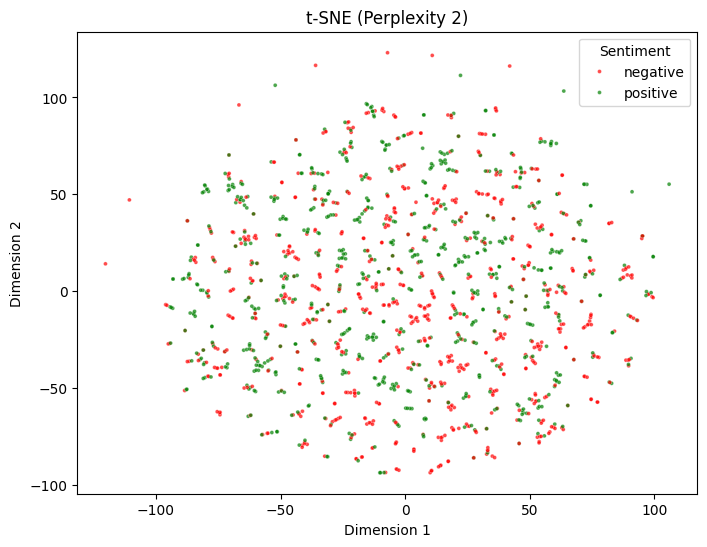

In [101]:
# Set t-SNE paramters
tsne_params = {
  "n_components": 2,
  "init": "random",               # Random initialization
  "random_state": 2025,
  "perplexity": None,             # To be set dynamically
  "max_iter": 1000,               # Maximum interatio
  "n_iter_without_progress": 100, # Stop if no progress
  "metric": "cosine",             # Use cosine similarity
  "early_exaggeration": 30,       # Tightness of natural clusters
  "learning_rate": "auto",        # Auto learning rate
  "angle": 0.0000001              # Gradient threshold
}

# Convert TF-IDF matrix to dense format for t-SNE
tfidf_matrix_dense = tfidf_matrix.toarray()

# Apply t-SNE for perplexity 2
for perplexity in [2]:
  tsne_params["perplexity"] = perplexity
  tsne = TSNE(**tsne_params)
  tsne_embedding = tsne.fit_transform(tfidf_matrix_dense)

  # Plot results
  plt.figure(figsize=(8, 6))
  sns.scatterplot(
      x=tsne_embedding[:, 0],
      y=tsne_embedding[:, 1],
      hue=df["Sentiment"],
      palette= sns.color_palette(["red", "green"]),
      alpha=0.7,
      s=8
  )
  plt.title(f"t-SNE (Perplexity {perplexity})")
  plt.xlabel("Dimension 1")
  plt.ylabel("Dimension 2")
  plt.legend(title="Sentiment", loc="best")
  plt.show()

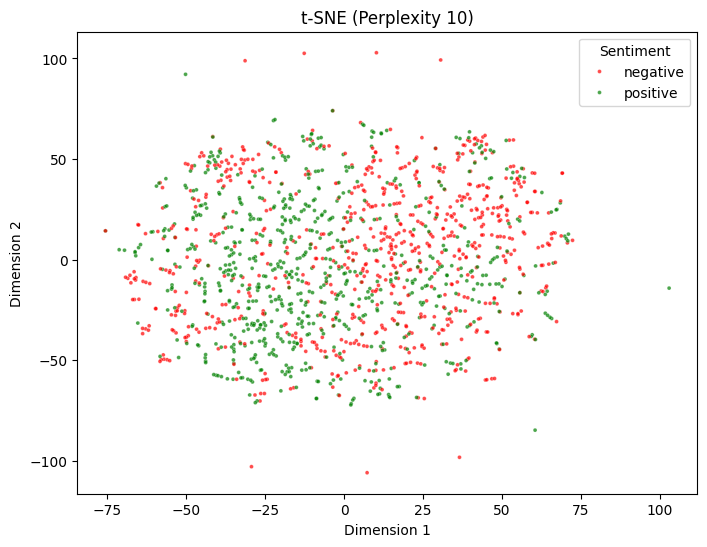

In [102]:
# Apply t-SNE for perplexity 10
for perplexity in [10]:
  tsne_params["perplexity"] = perplexity
  tsne = TSNE(**tsne_params)
  tsne_embedding = tsne.fit_transform(tfidf_matrix_dense)

  # Plot results
  plt.figure(figsize=(8, 6))
  sns.scatterplot(
      x=tsne_embedding[:, 0],
      y=tsne_embedding[:, 1],
      hue=df["Sentiment"],
      palette= sns.color_palette(["red", "green"]),
      alpha=0.7,
      s=8
  )
  plt.title(f"t-SNE (Perplexity {perplexity})")
  plt.xlabel("Dimension 1")
  plt.ylabel("Dimension 2")
  plt.legend(title="Sentiment", loc="best")
  plt.show()

**Written Answer:**

Comparing the two t_SNE projections, the Perplexity = 10 visualization appears to provide a slightly better structure than the Perplexity = 2 visualization, but neither achieves a strong class separation. With 2, the points are highly localized, leading to many small, scattered clusters that overemphasize local relationships without capturing the overall structure of the data. In contrast, 10 produces a more globally aware distribution, where the points are spread out more evenly, allowing for some regional grouping of sentiment labels. However, both projections still exhibit significant overlap between positive and negative reviews, suggesting that the features used (TF-IDF) may not effectively distinguish sentiment in a way that t-SNE can separate. Given this, 10 is the better of the two, as it captures a broader structure of the data while maintaining some local coherence, but additional feature engineering (e.g., word embeddings) may be necessary for clearer sentiment-based separation.

## Question 2.5: UMAP

(1) Apply **UMAP**. Set:
- number of components to 2
- use 10 nearest neighbors
- use cosine metric
- number of training epochs to 1000
- effective minimum distance between embedded points to 0.1
- effective scale of embedded points to 1
- avoids excessive memory use
- do not use a random seed to allow parallel processing.

(2) Create a plot, showing 2D projection of our data using UMAP. Remember to add labels and title.

In [103]:
# Set UMAP parameters
umap_params = {
  "n_components": 2, # Project into 2D
  "n_neighbors": 10, # 10 nearest neighbours
  "metric": "cosine", # Use cosine similarity
  "n_epochs": 1000, # Number of training epochs
  "min_dist": 0.1, # Minimum distance between embedded points
  "spread": 1,      # Effective scale of embedded points
  "verbose": True,
  "set_op_mix_ratio": 1
}

# Convert TF-IDF matrix to dense dormat for UMAP
tfidf_matrix_dense = tfidf_matrix.toarray()

# Apply UMAP
umap_embedding = umap.UMAP(**umap_params).fit_transform(tfidf_matrix_dense)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP(angular_rp_forest=True, metric='cosine', n_epochs=1000, n_neighbors=10, set_op_mix_ratio=1, spread=1, verbose=True)
Wed Mar 19 21:23:26 2025 Construct fuzzy simplicial set
Wed Mar 19 21:23:29 2025 Finding Nearest Neighbors
Wed Mar 19 21:23:29 2025 Finished Nearest Neighbor Search
Wed Mar 19 21:23:29 2025 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Wed Mar 19 21:23:32 2025 Finished embedding


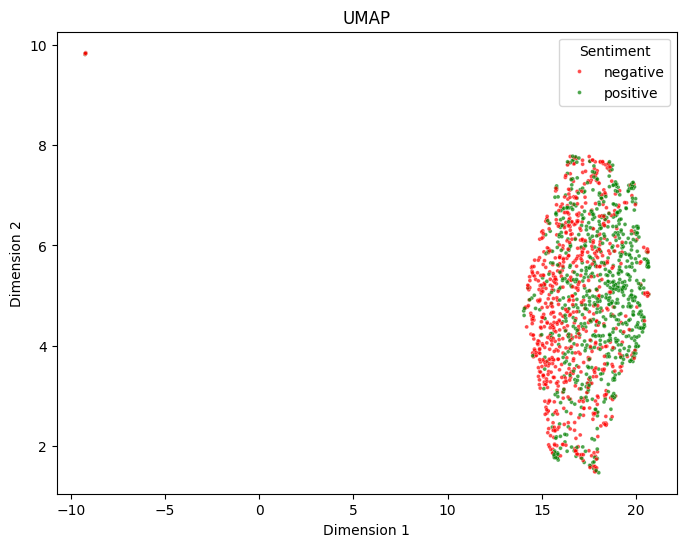

In [104]:
# Plot results
plt.figure(figsize=(8, 6))
sns.scatterplot(
  x=umap_embedding[:, 0],
  y=umap_embedding[:, 1],
  hue=df["Sentiment"],
  palette= sns.color_palette(["red", "green"]),
  alpha=0.7,
  s=8
)
plt.title("UMAP")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Sentiment", loc="best")
plt.show()

## Question 2.6: t-SNE vs UMAP

Compare t-SNE (perplexity 10) and UMAP. Comment on your findings.

**Written answer:**

Comparing t_SNE with Perplexity = 10 and UMAP, UMAP appears to offer better sentiment separation and a more structured embedding. In the t-SNE projection, positive and negative sentiment points were widely dispersed with significant overlap, indicating that t-SNE struggled to capture a clear distinction between the two classes. In contrast, UMAP produces a more compact and organized structure, where sentiment classes show a stronger regional separation, though some overlap remains. This suggests that UMAP, with its ability to preserve both local and global structures, may be better suited for this dataset than t-SNE, which primarily excels in local relationships but can struggle with global structure. Additionally, UMAP's denser clustering suggests that it retains semantic similarities more effectively, potentially making it a stronger choice for tasks that require interpretable low-dimensional embeddings of text data.